# 2 Fidelity
## 2.1 tSNE and PCA plots
We apply t-SNE and PCA (Principle Component Analysis) analyses on both the original and synthetic
datasets (flattening the temporal dimension). This visualizes how closely the distribution of generated
samples resembles that of the original in 2-dimensional space,

_More explanation of t-SNE:_  

   *T-SNE can reduce a multi-column (i.e.multidimensional) data to 2D (or 3D) so that it can be visualised. It is an unsupervised machine learning algorithm studying how to group 'similar' data together (by measuring the difference between each columns and the probability of showing up) . We cannot interpret why a data fall on that position in the 2D plot, but we can compare whether the real data and synthetic data have similar patterns in the 2D plot.*

In [5]:
import numpy as np
import pandas as pd
#Load and preprocess real and synthetic data.
#All are dataframes in shape (no_sample * time_seq, dimension)
dp_ori_df = pd.read_csv('synthetic data/doppelGANger/dp_ori.csv') #dataframe of shape(1347*130, 5), originally ori_features_prism.npy
dp_gen_df = pd.read_csv('synthetic data/doppelGANger/dp_gen.csv') #dataframe of shape(1347*130, 5), originally features_600.npy
tgan_ori_df = pd.read_csv('synthetic data/TGAN/tgan_ori.csv') #dataframe of shape (1239*10, 10), same for all below, originally cat_time_10visits_all_noid.csv
tgan_gen_df = pd.read_csv('synthetic data/TGAN/tgan_gen.csv') #originally gen_cat_time_10visits_wl_5000it.npy
ori_df = pd.read_csv('synthetic data/2/cat_time_5abovevisits_all.csv') #originally cat_time_5abovevisits_all.csv
gen_1_df = pd.read_csv('synthetic data/2_no_id/gen_1_df.csv') #originally gen_cat_time_10visits_wl_5000it_hd10_nl5.npy
gen_2_df = pd.read_csv('synthetic data/2_no_id/gen_2_df.csv') #originally gen_cat_time_10visits_wl_5000it_hd10.npy
gen_3_df = pd.read_csv('synthetic data/2/gen_dop_cat_5abovevisits_d2g_e449.csv') #originally gen_dop_cat_5abovevisits_d2g_e449.npy
gen_4_df = pd.read_csv('synthetic data/2_no_id/gen_4_df.csv') #originally from gen_cat_time_10visits_all_5000it.npy.

In [56]:
def Stack2DSequence(df):
    '''
    Transform a df in 2D shape into 3D by putting the data for the sampe patient ('id') in each layer, the \
    resulting shape is (no. of sample, max(time_sequence),dimension of column). If the time sequence length
    of this patient is less than the max(time_sequence), then leave the remaining rows as zero.
    '''
    df_dropid = df.drop(columns=['id'])
    idcount = df['id'].value_counts()
    no_of_sample = len(idcount)
    time_seq_len = np.max(idcount)
    cols = (df_dropid.keys()).tolist()
    stacked_array = np.zeros((no_of_sample,time_seq_len,len(cols)))
    n = 0
    t = 0
    id_ini = df['id'][0]
    for i in list(df_dropid.index):
    #     display(n)
        id_ = df['id'][i]
        if id_ini == id_:
            stacked_array[n][t] = df_dropid.iloc[i,:]
            t += 1
        else:
            n += 1
            t = 0
            stacked_array[n][t] = df_dropid.iloc[i,:]
            id_ini = id_
    return stacked_array

In [60]:
def CutTimeSequence(a,time_sequence): 
    '''A function which transforms temporal-sequence-flattened dataframe or array (e.g. the loaded dataframes) to array in shape (no_sample, time_seq, dimension)
    
    Args:
    a: the dataframe or array in shape (no_sample * time_seq, dimension)
    time_sequence: the time_seq argument in the shape of the returned array
    
    Returns:
    new_a : array in new shape (no_sample, time_seq, dimension)
    
    '''
    if type(a)==pd.core.frame.DataFrame:
        a = a.values
    l,d = a.shape
    new_a = np.zeros((int(l/time_sequence),time_sequence,d))
    for i in range(l):
        new_a[int(i/time_sequence),i%time_sequence,:]=a[i,:]
    return new_a

In [100]:
ori_df.sort_values(by=['id'],inplace = True)
gen_3_df.sort_values(by=['id'], inplace = True)
ori_3d = Stack2DSequence(ori_df) #shape (1347,130,10)
gen_3_3d = Stack2DSequence(gen_3_df) #shape (1347,127,10)

In [104]:
dp_ori_data = CutTimeSequence(dp_ori_df,130) #shape (1347,130,5)
dp_gen_data = CutTimeSequence(dp_gen_df,130) #shape (1347,130,5)
tgan_ori_data = CutTimeSequence(tgan_ori_df,10) #shape (1239,10,10), same for all below
tgan_gen_data = CutTimeSequence(tgan_gen_df,10)
gen_1_3d = CutTimeSequence(gen_1_df,10)
gen_2_3d = CutTimeSequence(gen_2_df,10)
gen_4_3d = CutTimeSequence(gen_4_df,10)

In [105]:
#fill all NaN's in data with 0
tgan_ori_data[np.isnan(tgan_ori_data)]=0
tgan_gen_data[np.isnan(tgan_gen_data)]=0
gen_1_3d[np.isnan(gen_1_3d)]=0
gen_2_3d[np.isnan(gen_2_3d)]=0
gen_3_3d[np.isnan(gen_3_3d)]=0
gen_4_3d[np.isnan(gen_4_3d)]=0
ori_3d[np.isnan(ori_3d)]=0

In [106]:
#Set up a dictionary for the future loop
synthetic_data_dic = {'DoppelGANger ini':[dp_ori_data, dp_gen_data],'tGAN':[tgan_ori_data,tgan_gen_data],\
                      'gen 1':[tgan_ori_data,gen_1_3d],'gen 2':[tgan_ori_data,gen_2_3d],'gen 3':[ori_3d,gen_3_3d],\
                     'gen 4':[tgan_ori_data,gen_4_3d]}
syn_keys = list(synthetic_data_dic.keys())
n = len(syn_keys)

In [102]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

   
def visualization (ori_data, generated_data, analysis,syn_name = None):
    """Using PCA or tSNE for generated and original data visualization.
    (Originally from tGAN code, updated by Aisha to allow ori_data and generated_data to have different time_sequence_length)

    Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
    - syn_name: the name of the synthetic generator
    """  
    # Analysis sample size (for faster computation)
    anal_sample_no = min([1000, len(ori_data),len(generated_data)])
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    # Data preprocessing
    ori_data = np.asarray(ori_data)
    generated_data = np.asarray(generated_data)  

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    def SameTimeSeq(ori_data,gen_data):
        #make time_seq_o and time_seq_g of a pair of ori_df and gen_df the same to get tSNE and PCA work; we achieve this
        #by padding zeros to the shorter time_seq df.
        no_o, time_seq_o, d = ori_data.shape
        no_g, time_seq_g, d = gen_data.shape
        time_seq = max(time_seq_o,time_seq_g)
        if time_seq_o != time_seq_g:
            if time_seq_g < time_seq_o:
                padding = np.zeros((no_g,time_seq_o-time_seq_g,d))
                gen_data = np.concatenate((gen_data,padding),axis = 1)
            else:
                padding = np.zeros((no_o,time_seq_g-time_seq_o,d))
                ori_data = np.concatenate((ori_data,padding),axis = 1)
        return ori_data,gen_data,time_seq

    ori_data, generated_data, seq_len = SameTimeSeq(ori_data, generated_data)

    for i in range(anal_sample_no):
        if (i == 0):
          prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
          prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
        else:
          prep_data = np.concatenate((prep_data, 
                                      np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
          prep_data_hat = np.concatenate((prep_data_hat, 
                                          np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))

    # Visualization parameter        
    colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]    

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components = 2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data) #PCA coordinates for the real data
        pca_hat_results = pca.transform(prep_data_hat) #PCA coordinates for the synthetic data

        # Plotting
        f, ax = plt.subplots(1)    
        plt.scatter(pca_results[:,0], pca_results[:,1],
                    c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
        plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                    c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")

        ax.legend()  
        plt.title(syn_name+' '+'PCA plot')
        plt.xlabel('x-pca')
        plt.ylabel('y_pca')
        plt.show()

    elif analysis == 'tsne':

        # Do t-SNE Analysis together       
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)

        # TSNE anlaysis
        tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
        tsne_results = tsne.fit_transform(prep_data_final) #tSNE coordinates, 
        #for [:anal_sample_no, : ] are the coordinates for the original,
        #for [anal_sample_no: , : ] are the coordinates for the generated

        # Plotting
        f, ax = plt.subplots(1)

        plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                    c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
        plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                    c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")

        ax.legend()

        plt.title(syn_name+' '+'t-SNE plot')
        plt.xlabel('x-tsne')
        plt.ylabel('y_tsne')
        plt.show()    
        
        


## Visualisation of PCA and tSNE plots for every synthetic datasets

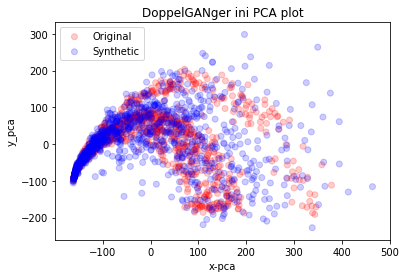

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.011s...
[t-SNE] Computed neighbors for 2000 samples in 1.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 22.468205
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.817993
[t-SNE] KL divergence after 300 iterations: 0.756296


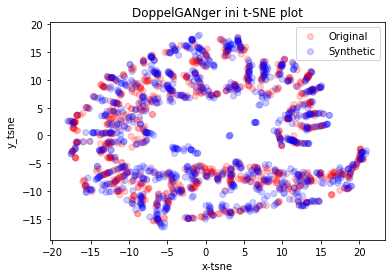

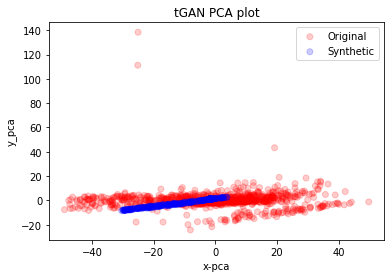

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.001550
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.654137
[t-SNE] KL divergence after 300 iterations: 0.999350


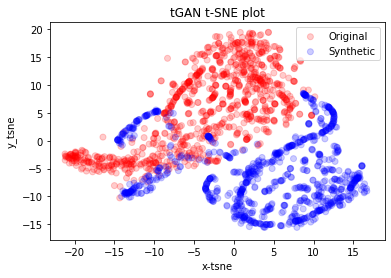

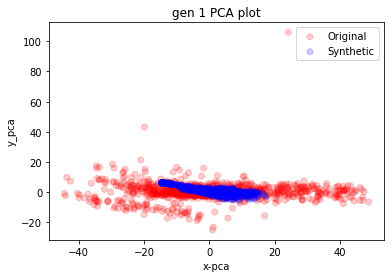

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.738890
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.105934
[t-SNE] KL divergence after 300 iterations: 1.102965


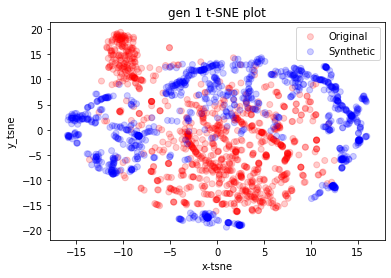

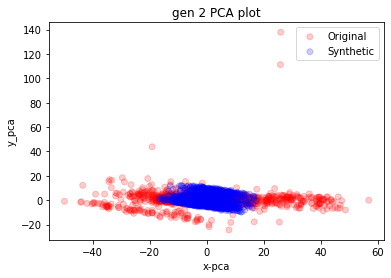

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.006s...
[t-SNE] Computed neighbors for 2000 samples in 0.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 4.363643
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.365204
[t-SNE] KL divergence after 300 iterations: 1.664653


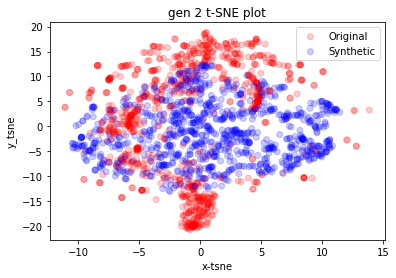

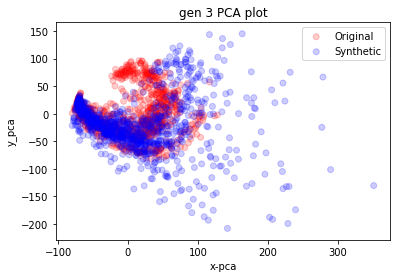

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.013s...
[t-SNE] Computed neighbors for 2000 samples in 2.189s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 12.065052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.474869
[t-SNE] KL divergence after 300 iterations: 0.835643


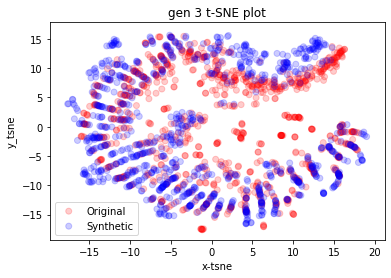

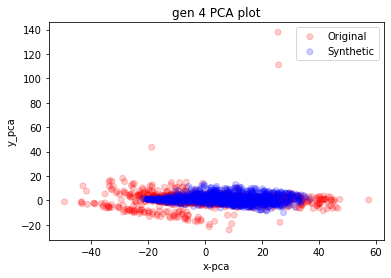

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 3.198257
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.498688
[t-SNE] KL divergence after 300 iterations: 1.306001


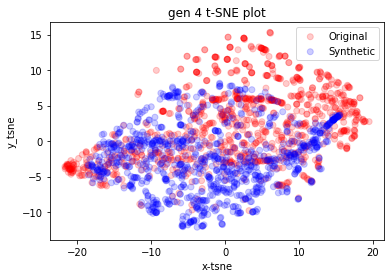

In [108]:
for i in range(n):
    key = syn_keys[i]
    visualization(synthetic_data_dic[key][0], synthetic_data_dic[key][1], 'pca',syn_name = key)
    visualization(synthetic_data_dic[key][0], synthetic_data_dic[key][1], 'tsne',syn_name = key)

## Conclusion 
* DoppelGANger ini and gen 3 give satisfactory results.
* Among gen 1, gen 2 and gen 4, gen 4 gives the best result.

References:
* <!--[Text](link)-->
[Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar. Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks.pdf 'Optional title')
